<a href="https://colab.research.google.com/github/manuel103/Machine-Learning/blob/master/CAT1_California_Housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model,metrics
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split,KFold,cross_val_score,GridSearchCV,RandomizedSearchCV

# from sklearn.preprocessing import Imputer
from sklearn.impute import SimpleImputer # class to handle missing values

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Data Exploration: Making Sense of the Data by Analyzing Attributes & Visualizing

In [0]:
housing = pd.read_csv('housing.csv')
# housing.head()
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


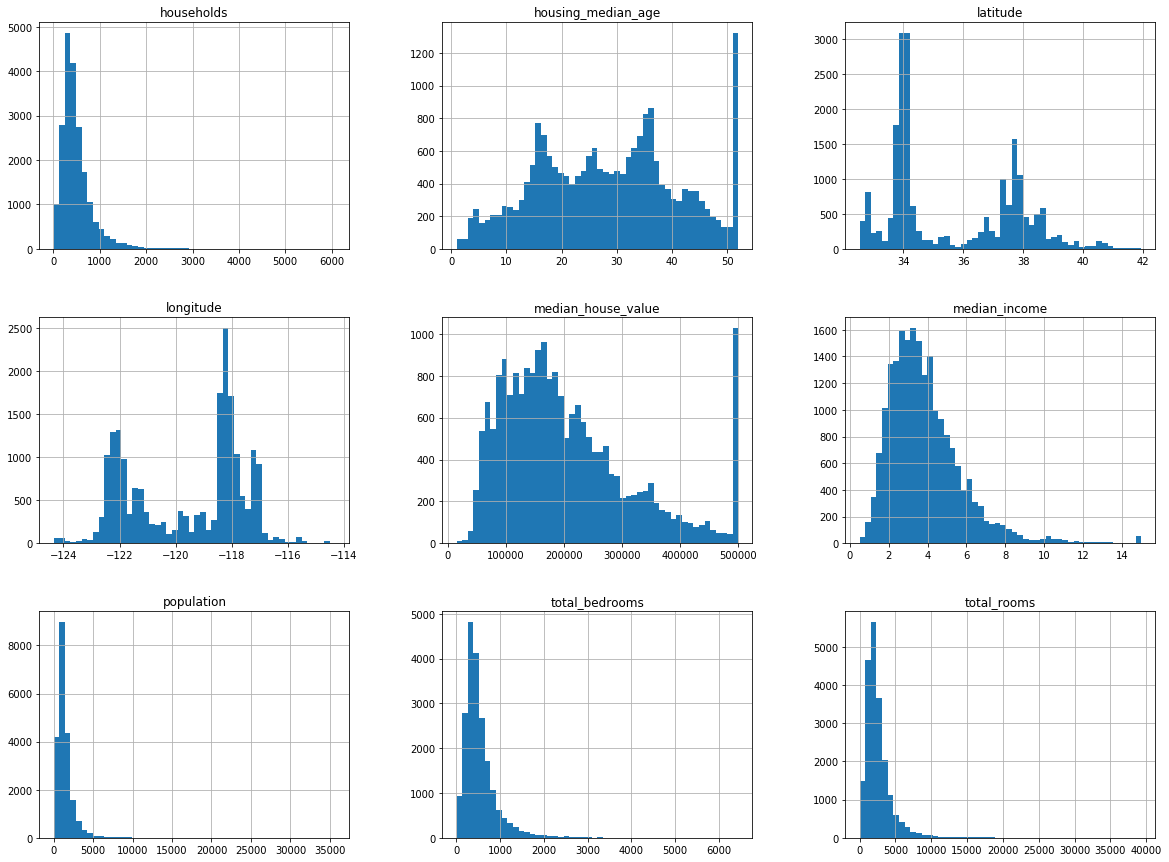

In [0]:
housing.hist(bins=50, figsize=(20,15))
plt.show()

## (i) Data Preprocessing
### 1. Handling missing values

In [0]:
df = housing.copy()
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

**Total Bedrooms has the Most Missing Values (207)**

In [0]:
# statistical description of missing values column
df['total_bedrooms'].describe()

count    20433.000000
mean       537.870553
std        421.385070
min          1.000000
25%        296.000000
50%        435.000000
75%        647.000000
max       6445.000000
Name: total_bedrooms, dtype: float64

**Checking if the Column has a Large Number of Outliers by Viewing Data Distribution**

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

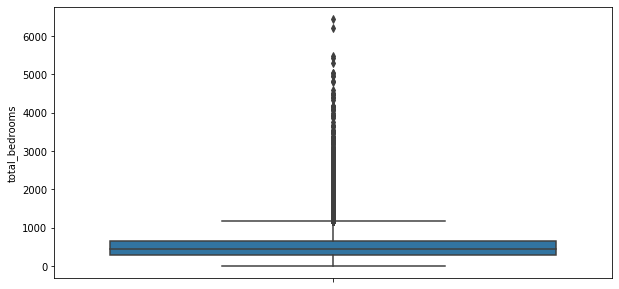

In [0]:
# boxplot on total_bedrooms
plt.figure(figsize=(10,5))
sns.boxplot(y='total_bedrooms',data=df)
plt.plot

**To deal with missing values, we set the values to some value, i.e Their median, using sklearn's *imputer*. This is because the column 'total_bedrooms' has a lot of outliers and handling them in a different way will affect the prediction.** 

In [0]:
'''
Filling the missing values of total_bedrooms based upon categories of ocean_proximity
'''
imputer = Imputer(strategy='median')
housing_num = df.drop('ocean_proximity', axis=1) # convert to numerical
imputer.fit(housing_num)
# imputer.statistics_
housing_num.median().values


/home/emmanuel/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


array([-1.1849e+02,  3.4260e+01,  2.9000e+01,  2.1270e+03,  4.3500e+02,
        1.1660e+03,  4.0900e+02,  3.5348e+00,  1.7970e+05])

**Replacing missing values with the medians**

In [0]:
X = imputer.transform(housing_num)
# X
housing_tr = pd.DataFrame(X, columns=housing_num.columns)# converting the numpy array back to a DataFrame
housing_tr

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0
...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0


In [0]:
housing_tr.isnull().sum() # Now there are no missing values

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
dtype: int64

In [0]:
len(housing_tr)

20640

### 2. Feature Selection

**Preparing Data for Encoding Using PCA**

In [0]:
pre_data = housing.drop(columns=['median_house_value'],axis=1)
all_features = list(pre_data.columns)
len(all_features)

9

In [0]:
categorical_data=housing.select_dtypes(include=['object']).copy()
categorical_features=list(categorical_data.columns)
#categorical_data.head()
categorical_features

['ocean_proximity']

In [0]:
nominal=['ocean_proximity']
ordinal=list(set(categorical_features)-set(nominal))
numerical=list(set(all_features)-set(categorical_features))
target=['median_house_value']

for feature in categorical_features:
  categorical_data[feature]=categorical_data[feature].astype('category')
for feature in ordinal:
  categorical_data[feature]=categorical_data[feature].cat.codes
categorical_data.head()

,ocean_proximity
0,NEAR BAY
1,NEAR BAY
2,NEAR BAY
3,NEAR BAY
4,NEAR BAY


### 3. Encoding

**Converting categorical values into one-hot vectors using *one hot encoding technique***

In [0]:
data_copy=categorical_data.copy()

data_copy = pd.concat([pd.get_dummies(data_copy[nominal]),data_copy],axis=1) 
data_copy.drop(nominal,axis=1,inplace=True)

new_data = pd.concat([data_copy,housing_tr[numerical],housing_tr[target]],axis=1)
new_data

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN,longitude,total_bedrooms,population,households,median_income,latitude,housing_median_age,total_rooms,median_house_value
0,0,0,0,1,0,-122.23,129.0,322.0,126.0,8.3252,37.88,41.0,880.0,452600.0
1,0,0,0,1,0,-122.22,1106.0,2401.0,1138.0,8.3014,37.86,21.0,7099.0,358500.0
2,0,0,0,1,0,-122.24,190.0,496.0,177.0,7.2574,37.85,52.0,1467.0,352100.0
3,0,0,0,1,0,-122.25,235.0,558.0,219.0,5.6431,37.85,52.0,1274.0,341300.0
4,0,0,0,1,0,-122.25,280.0,565.0,259.0,3.8462,37.85,52.0,1627.0,342200.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20635,0,1,0,0,0,-121.09,374.0,845.0,330.0,1.5603,39.48,25.0,1665.0,78100.0
20636,0,1,0,0,0,-121.21,150.0,356.0,114.0,2.5568,39.49,18.0,697.0,77100.0
20637,0,1,0,0,0,-121.22,485.0,1007.0,433.0,1.7000,39.43,17.0,2254.0,92300.0
20638,0,1,0,0,0,-121.32,409.0,741.0,349.0,1.8672,39.43,18.0,1860.0,84700.0


### 4. Feature Extraction & Dimensionality Reduction using PCA with 90% variance

In [0]:
all_features = list(new_data.columns)
# all_features
X = new_data.loc[:,all_features[0]:all_features[-2]].values
y = new_data.loc[:,[all_features[-1]]].values
y

array([[452600.],
       [358500.],
       [352100.],
       ...,
       [ 92300.],
       [ 84700.],
       [ 89400.]])

**Transforming both X and y to Gaussian Distribution using *PowerTransformer* Class Which Enforces a Gaussian Distribution**

In [0]:
X = PowerTransformer().fit_transform(X)
y = PowerTransformer().fit_transform(y)
# X
y

array([[ 1.71807808],
       [ 1.26294108],
       [ 1.22831393],
       ...,
       [-1.13928351],
       [-1.2781533 ],
       [-1.19104913]])

**90% PCA variance**

In [0]:
pca_with_varia = PCA(0.9)
pca_with_varia.fit_transform(X)
pca_with_varia.n_components_

7

**Using 2 Principal Components**

In [0]:
pca = PCA(n_components=2)
pc_s = pca.fit_transform(X)
pca_data = pd.DataFrame(pc_s,columns=['PC1','PC2'])
target_data = pd.DataFrame(y,columns=['median_house_value'])
final_data = pd.concat([pca_data,target_data],axis=1)
final_data

,PC1,PC2,median_house_value
0,-3.366110,1.673565,1.718078
1,2.657383,2.934477,1.262941
2,-2.627586,1.859894,1.228314
3,-2.441749,1.941577,1.168611
4,-2.142396,2.090290,1.173649
...,...,...,...
20635,-1.164049,1.975475,-1.407902
20636,-3.133140,1.491283,-1.428392
20637,-0.345797,2.157570,-1.139284
20638,-0.939459,2.046786,-1.278153


In [0]:
final_data.describe()

,PC1,PC2,median_house_value
count,2.064000e+04,2.064000e+04,2.064000e+04
mean,-1.144111e-17,-1.529870e-15,-1.470142e-15
std,1.988788e+00,1.596331e+00,1.000024e+00
min,-8.984070e+00,-3.616911e+00,-3.780890e+00
25%,-1.142277e+00,-1.510814e+00,-7.114094e-01
50%,-9.092657e-02,-1.734452e-01,-1.052064e-02
75%,1.110838e+00,1.487522e+00,6.902740e-01
max,1.097759e+01,4.056506e+00,1.916642e+00


## (ii) Data Distributions Examination

**Examining the Distributions of Principal Components Using Seaborn**

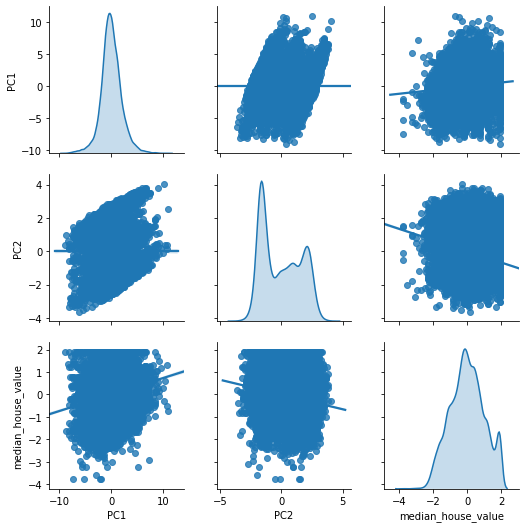

In [0]:
import seaborn as sns
sns.pairplot(final_data,kind='reg', diag_kind='kde')

**Converting the Raw *final_data_array* to a Numpy Array (For Further Processing)**

In [0]:
final_data_array = final_data.to_numpy()
final_data_array

array([[-3.36610982,  1.67356455,  1.71807808],
       [ 2.65738265,  2.93447715,  1.26294108],
       [-2.6275863 ,  1.85989429,  1.22831393],
       ...,
       [-0.34579747,  2.15757048, -1.13928351],
       [-0.93945936,  2.04678603, -1.2781533 ],
       [ 0.40981658,  2.24767912, -1.19104913]])

In [0]:
all_features = list(final_data.columns)
all_features
X_2 = final_data.loc[:,all_features[0]:all_features[-2]].values
y_2 = final_data.loc[:,[all_features[-1]]].values

## (iii) Model Selection

**Splitting data to training & testing data**

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_2,y_2,test_size=0.3,random_state=0)

In [0]:
# Normalising the Data
from sklearn.preprocessing import MinMaxScaler
ms=MinMaxScaler()
X_train=ms.fit_transform(X_train)
X_test=ms.transform(X_test)


**Evaluating the Different Regression Models to Select the Best**

* We Compare the Different Regression Coefficients for all the Models
* The comparison coefficients are:

1. Cross Validation Accuracy
2. Cross Validation Variance
3. Root Mean Squared Error

In [0]:
# RMSE function
def evaluate(ypred,ytest,regressor):
    print("root mean squared error for test data   is "+str(np.sqrt(mean_squared_error(ytest,ypred))))

In [0]:
from sklearn.metrics import mean_squared_error

# Regressor Model
def regressor_model(x,y,estimator):
   
    regressor=estimator()
    regressor.fit(x,y)
    lr_rmse=np.sqrt(mean_squared_error(y,regressor.predict(x)))
    cv_regressor=cross_val_score(cv=10,X=x,y=y,estimator=regressor,scoring='r2')
    print('The cross validation accuracy is - '+str(100*cv_regressor.mean()))
    print('The cross validation variance is - '+str(100*cv_regressor.std()))
    return regressor

### 1. LinearRegression

In [0]:
from sklearn.linear_model import LinearRegression

l=regressor_model(X_train,y_train,LinearRegression)
evaluate(l.predict(X_test),y_test,l)

The cross validation accuracy is - 6.167765997905144
The cross validation variance is - 1.5853199278842534
root mean squared error for test data   is 0.9664874796026063


### 2. Lasso

In [0]:
from sklearn.linear_model import Lasso

l=regressor_model(X_train,y_train,Lasso)
evaluate(l.predict(X_test),y_test,l)


The cross validation accuracy is - -0.13104822563485996
The cross validation variance is - 0.14698164026819374
root mean squared error for test data   is 1.0015387746410058


### 3. Ridge

In [0]:
from sklearn.linear_model import Ridge

l=regressor_model(X_train,y_train,Ridge)
evaluate(l.predict(X_test),y_test,l)


The cross validation accuracy is - 6.168080856821039
The cross validation variance is - 1.5793181083778232
root mean squared error for test data   is 0.9665113513756696


### 4. Elastic Net

In [0]:
from sklearn.linear_model import  ElasticNet

l=regressor_model(X_train,y_train,ElasticNet)
evaluate(l.predict(X_test),y_test,l)

The cross validation accuracy is - -0.13104822563485996
The cross validation variance is - 0.14698164026819374
root mean squared error for test data   is 1.0015387746410058


#### The Model With the Best HyperParameter and Least Variance is Chosen, i.e Lasso or Elastic Net

## (iv) Hyperparameter Tuning (Randomized)
**We Use Sklearn's GridSearchCV for Data Splitting and Tuning of HyperParameters <br>
and Later Try Tuning Our HyperParameters by Applying the Results to Our Random Forest Model**

In [0]:
from sklearn.model_selection import GridSearchCV

# Data Splitting using GridSearchCV
params=[{
            
            'max_depth':[2,3,4,5,6,10,20,30,40,50,60,70,100],
            'min_samples_split':[2,3,4,7,10,12],
            'min_samples_leaf' :[1,3,5,10,15,20,25],
            'max_features':['sqrt','log2'],
            
        }
        ]

gc=GridSearchCV(dt,params,cv=10,scoring='r2',n_jobs=-1)# Performing a cross validation of 10 folds
gc.fit(X_train,y_train)
gc.best_estimator_ # Finding the best estimator learnt from our grid search model

'''
In the first row of params we are saying to try 13 combinations
In the second row of params we are saying to try 6 combinations
In the third row of params we are saying to try 7 combinations
So, in total, 26 combinations

'''

DecisionTreeRegressor(criterion='mse', max_depth=10, max_features='log2',
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=25,
                      min_samples_split=7, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [0]:
gc.best_score_

0.11647734865022132

#### Random Forest

In [0]:
from sklearn.ensemble import RandomForestRegressor

rg=RandomForestRegressor(n_estimators=10)
rg.fit(X_train,y_train)

/home/emmanuel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

#### Finding the Best Features Based on the Random Forest

## (v) Cross Validation

### Here We Demonstrate K-Fold Cross Validation Using a Decision Tree on Our Model

#### 1. Creating a Decision Tree

In [0]:
'''
Creating the decision tree by Calling our regressor_model & 
Passing DecisionTreeRegressor Class, X_train & y_trains as Arguments
'''
dt=regressor_model(X_train,y_train,DecisionTreeRegressor)
dt.fit(X_train,y_train)
print('mean squared errror is',end='\t-')
np.sqrt(mean_squared_error(y_test,dt.predict(X_test)))

The cross validation accuracy is - -60.444873152621405
The cross validation variance is - 5.882450295257773
mean squared errror is	-

1.270031764545244

#### 2. Performing K-Fold Cross Validation Starting With K = 10 and r2 Scoring

In [0]:
cv=cross_val_score(dt,X_train,y_train,scoring='r2',cv=10)
print('Standard Deviation is: ', cv.std())
print('Mean is: ', cv.mean())

Standard Deviation is:  0.05342085004933257
Mean is:  -0.6014433539271369


#### 3. Performing K-Fold Cross Validation Starting With K = 20 and r2 Scoring

In [0]:
cv=cross_val_score(dt,X_train,y_train,scoring='r2',cv=20)
print('Standard Deviation is: ', cv.std())
print('Mean is: ', cv.mean())

Standard Deviation is:  0.08875307445640289
Mean is:  -0.5777831180117421


### Observation:
**Increasing the value of K(cv) results to an increased accuracy of our model.<br>This is because a higher K results to a more accurate confidence interval as a result of overfitting. Overfitting occurs as a result of the correlation between the trained K models.**